In [1]:
import numpy as np
import cv2
from matplotlib.pyplot import plot
from pathlib import Path
from itertools import combinations
import matplotlib.pyplot as plt
import utils
from utils import to_homo

In [2]:
DATA_ROOT_PATH = Path('data')
IMG_PATH =  DATA_ROOT_PATH / 'q3.png'
ANNOTATIONS_PATH = DATA_ROOT_PATH / 'q3' / 'q3.npy'

COLORS = [(0, 255, 0), (0, 255, 255), (255, 255, 0), (255, 0, 0), (0, 0, 255)]

In [3]:
image = utils.load_image(IMG_PATH)

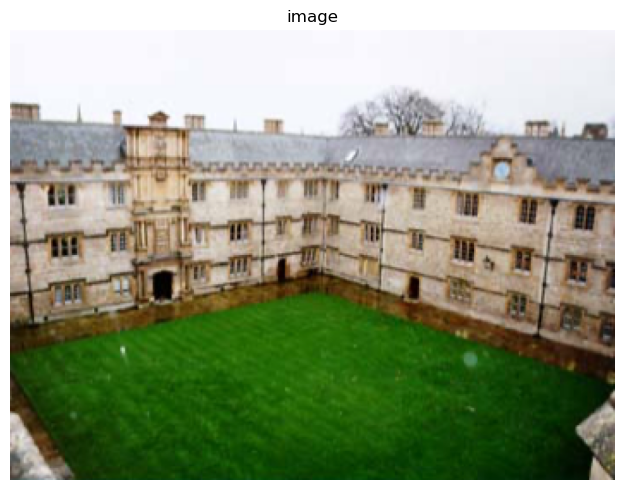

In [4]:
utils.show_images([image], ['image'])

In [5]:
annotations = np.load(ANNOTATIONS_PATH)

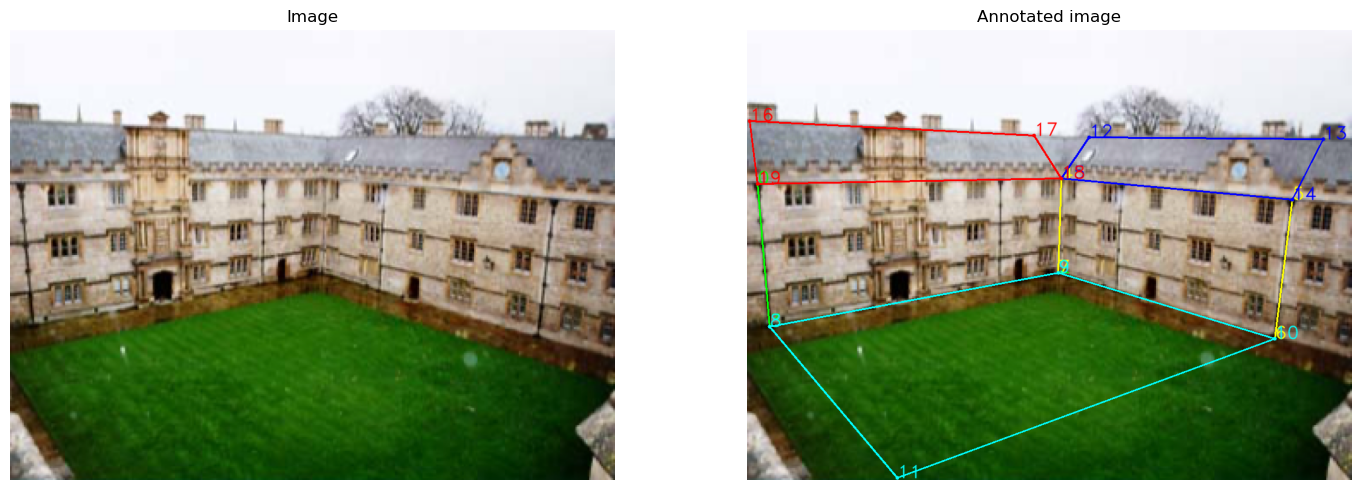

In [6]:
annotated_img = image.copy()

for i in range(annotations.shape[0]):
    COLOR = COLORS[i]
    square = annotations[i]
    for j in range(square.shape[0]):
        x, y = square[j]
        cv2.circle(annotated_img, (x, y), 3, COLOR, -1)
        cv2.putText(
            annotated_img,
            str(j + i * 4),
            (x, y),
            cv2.FONT_HERSHEY_DUPLEX,
            1,
            COLOR,
            1,
            cv2.LINE_AA,
        )
        cv2.line(annotated_img, square[j], square[(j + 1) % 4], COLOR, 2)
    
utils.show_images([image, annotated_img], ['Image', 'Annotated image'])

In [7]:
print(annotations)
annotations.shape

[[[ 17 254]
  [519 245]
  [514 401]
  [ 37 490]]

 [[519 245]
  [901 280]
  [872 510]
  [514 401]]

 [[ 37 490]
  [514 401]
  [872 510]
  [248 740]]

 [[565 177]
  [952 180]
  [901 280]
  [519 245]]

 [[  4 150]
  [474 174]
  [519 245]
  [ 17 254]]]


(5, 4, 2)

In [8]:
planes = np.array([annotations[0, :, :], annotations[2, :, :]])
planes.shape

(2, 4, 2)

In [9]:
lines = []        

line = np.cross(to_homo(planes[0][0]), to_homo(planes[0][1]))
line = line / line[-1]
lines.append(line)
        
line = np.cross(to_homo(planes[0][2]), to_homo(planes[0][3]))
line = line / line[-1]
lines.append(line)

line = np.cross(to_homo(planes[0][0]), to_homo(planes[0][3]))
line = line / line[-1]
lines.append(line)

line = np.cross(to_homo(planes[0][1]), to_homo(planes[0][2]))
line = line / line[-1]
lines.append(line)

line = np.cross(to_homo(planes[1][0]), to_homo(planes[1][3]))
line = line / line[-1]
lines.append(line)

line = np.cross(to_homo(planes[1][1]), to_homo(planes[1][2]))
line = line / line[-1]
lines.append(line)

v_points = []

for i in range(0, len(lines), 2):
    v_point = np.cross(lines[i], lines[i + 1])
    v_point = v_point / v_point[-1]

    v_points.append(v_point)

v_pairs = list(combinations(v_points, 2))
print(v_points)
print(v_pairs)

[array([1.43843628e+03, 2.28516083e+02, 1.00000000e+00]), array([3.81032558e+02, 4.54958419e+03, 1.00000000e+00]), array([-229.06223967,  174.76037954,    1.        ])]
[(array([1.43843628e+03, 2.28516083e+02, 1.00000000e+00]), array([3.81032558e+02, 4.54958419e+03, 1.00000000e+00])), (array([1.43843628e+03, 2.28516083e+02, 1.00000000e+00]), array([-229.06223967,  174.76037954,    1.        ])), (array([3.81032558e+02, 4.54958419e+03, 1.00000000e+00]), array([-229.06223967,  174.76037954,    1.        ]))]


In [10]:
# Constract the A matrix Aw = 0
A = []

for vp in v_pairs:
    xi = vp[0][0]
    yi = vp[0][1]
    xj = vp[1][0]
    yj = vp[1][1]

    equ = [xi * xj + yi * yj, xi + xj, yi + yj, 1]
    A.append(equ)

_, _, vt = np.linalg.svd(A)
W =  vt[-1]
W = W / W[-1]

W = [
        [W[0], 0, W[1]],
        [0, W[0], W[2]],
        [W[1], W[2], W[3]]
    ]

W

[[9.45322726917892e-07, 0, -0.00048796246961713613],
 [0, 9.45322726917892e-07, -0.00033760241307703584],
 [-0.00048796246961713613, -0.00033760241307703584, 1.0]]

In [11]:
L = np.linalg.cholesky(W)
K = np.linalg.inv(L).T
K = K / K[2, 2]
K

array([[814.77013455,   0.        , 516.18611901],
       [ -0.        , 814.77013455, 357.12926757],
       [ -0.        ,   0.        ,   1.        ]])

In [12]:
def get_n_vector(plane, K):
    
    lines = []        
    
    line = np.cross(to_homo(plane[0]), to_homo(plane[1]))
    line = line / line[-1]
    lines.append(line)
            
    line = np.cross(to_homo(plane[2]), to_homo(plane[3]))
    line = line / line[-1]
    lines.append(line)
    
    line = np.cross(to_homo(plane[0]), to_homo(plane[3]))
    line = line / line[-1]
    lines.append(line)
    
    line = np.cross(to_homo(plane[1]), to_homo(plane[2]))
    line = line / line[-1]
    lines.append(line)
    
    v_points = []
    
    for i in range(0, len(lines), 2):
        v_point = np.cross(lines[i], lines[i + 1])
        v_point = v_point / v_point[-1]
    
        v_points.append(v_point)

    d1 = np.linalg.inv(K) @ v_points[0]
    d2 = np.linalg.inv(K) @ v_points[1]

    n = np.cross(d1, d2)
    
    return n

In [13]:
planes_equ = []

scale = 5

X_ref = scale * np.linalg.inv(K) @ to_homo(annotations[0][2])
n = get_n_vector(annotations[0], K)
a = -n.T @ X_ref

planes_equ.append((n, a))

n = get_n_vector(annotations[1], K)
a = -n.T @ X_ref
planes_equ.append((n, a))

n = get_n_vector(annotations[2], K)
a = -n.T @ X_ref
planes_equ.append((n, a))

X_ref = scale * np.linalg.inv(K) @ to_homo(annotations[0][1])
n = get_n_vector(annotations[3], K)
a = -n.T @ X_ref
planes_equ.append((n, a))

n = get_n_vector(annotations[4], K)
a = -n.T @ X_ref
planes_equ.append((n, a))

In [14]:
print(planes_equ)

[(array([-5.30341985, -1.29779391,  5.7981585 ]), -28.712546754505507), (array([-5.12663064,  0.74667697, -4.47404036]), 22.100403696192007), (array([-0.02549604, -2.53683952, -0.59113787]), 3.6383191320933697), (array([2.85632858, 2.99452772, 3.53389939]), -15.658274268853678), (array([ 1.19173232, -1.99139219, -1.77832013]), 7.500737564219739)]


In [17]:
def get_plane_mask(corners, H, W):
    mask = np.zeros((H, W), dtype=np.uint8)
    
    pts = corners.astype(np.int32).reshape((-1, 1, 2))
    
    cv2.fillPoly(mask, [pts], 1)
    
    return mask.astype(bool)
    
def reconstruct_scene(planes, masks, K, image):
    H, W = image.shape[:2]
    K_inv = np.linalg.inv(K)

    v, u = np.indices((H, W)) 
    
    pixel_coords = np.stack([u, v, np.ones_like(u)], axis=0).reshape(3, -1)

    all_3d_points = []
    all_colors = []

    for i, (n, a) in enumerate(planes):
        mask = masks[i].flatten()
        
        if np.sum(mask) == 0:
            continue

        coords_in_mask = pixel_coords[:, mask] 
        
        rays = K_inv @ coords_in_mask

        dot_product = n @ rays
        
        dot_product[np.abs(dot_product) < 1e-6] = 1e-6
        
        depths = -a / dot_product
        
        points_3d = rays * depths
        
        all_3d_points.append(points_3d.T)
        
        img_flat = image.reshape(-1, 3)
        colors = img_flat[mask]
        all_colors.append(colors)

    if not all_3d_points:
        return None, None
        
    final_points = np.concatenate(all_3d_points, axis=0)
    final_colors = np.concatenate(all_colors, axis=0)
    
    return final_points, final_colors

def plot_3d(points, colors):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    step = 1 
    
    c_norm = colors[::step] / 255.0
    
    ax.scatter(points[::step, 0], points[::step, 2], -points[::step, 1], c=c_norm, s=1)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Z (Depth)')
    ax.set_zlabel('-Y (Height)')
    
    plt.show()

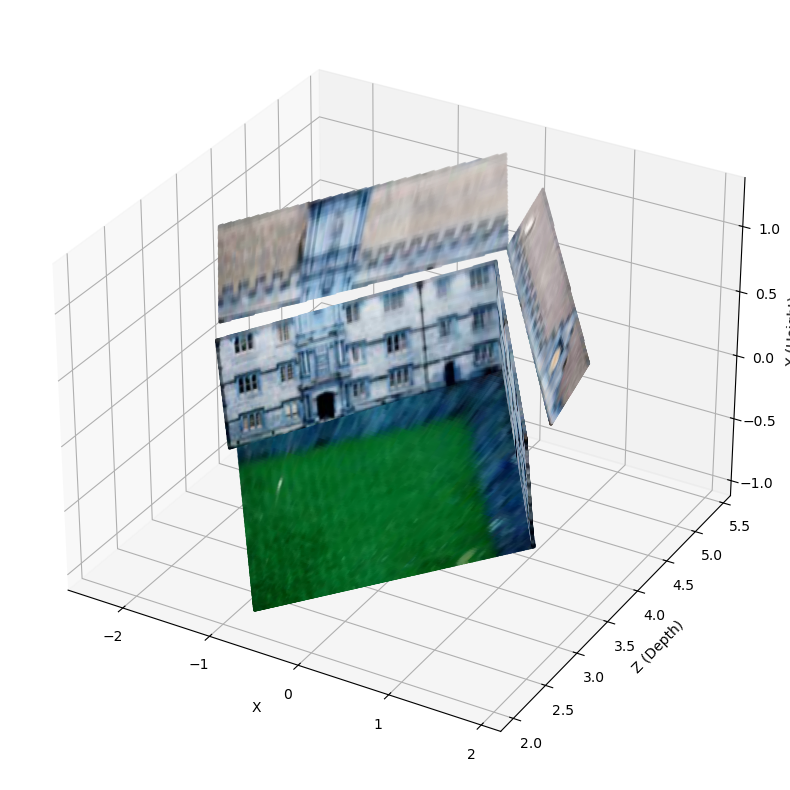

In [18]:
masks_list = []
H, W = image.shape[:2]

for corners in annotations:
    mask = get_plane_mask(corners, H, W)
    masks_list.append(mask)

pts, cols = reconstruct_scene(planes_equ, masks_list, K, image)
plot_3d(pts, cols)